In [ ]:
# hide
# default_exp top2vec

# Text Discovery with Top2Vec

> top2vec is an unsupervised topic detection algorithm. It finds clusters of similar texts and then groups them into meaningful topics.
* Get Topics
* Get Words
* Get Docs

# Look at:

* https://github.com/fastai/fastdoc
* https://github.com/fastai/fastpages

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# export

import logging
import os

import gensim
import numpy as np
import pandas as pd
from data_access.dremio_access import DremioAccess
from top2vec import Top2Vec

gensim.logger.setLevel(logging.WARN)

INFO:gensim.summarization.textcleaner:'pattern' package found; tag filters are available for English


In [ ]:
pd.set_option("display.max_colwidth", 800)

# Params

> These parameters are managed by papermill execution

In [ ]:
# export

traffic_percent = 1
speed = "fast-learn"
workers = 8

In [ ]:
# export
def get_traffic_text(percent):
    return str(percent) if int(percent) >= 10 else "0" + str(percent)

In [ ]:
assert get_traffic_text("3") == "03"
assert get_traffic_text("13") == "13"
assert get_traffic_text("78") == "78"

# Preprocess Data

In [ ]:
DremioAccess._get_dremio_password = lambda x: os.environ["DREMIO_PWD"]

In [ ]:
dremio_access = DremioAccess()

Please enter your AD password to connect to Dremio: ··············


In [ ]:
# export
def get_experiment_segment(traffic_percent):
    return tuple(get_traffic_text(tp) for tp in range(traffic_percent))

In [ ]:
assert get_experiment_segment(1) == ("00",)
assert get_experiment_segment(3) == ("00", "01", "02")
assert "' '".join(get_experiment_segment(1)) == "00"
assert f"""IN ('{"','".join(get_experiment_segment(3))}')""" == "IN ('00','01','02')"
assert len(get_experiment_segment(50)) == 50
assert max([int(x) for x in get_experiment_segment(100)]) == 99

In [ ]:
# export
def get_utterances(dremio_access, model, min_date, traffic_percent):
    segment = get_experiment_segment(traffic_percent)
    return dremio_access.read_sql_to_dataframe(
        f"""
    select Utterance from "chatbot_unpublish_s3"."lambda-output"."finn_feedback"
    where model = '{model}' and to_date(substr("Timestamp", 0, 10), 'YYYY-MM-dd') >= to_date('{min_date}', 'YYYY-MM-dd')
    and substr(AccountNumber, 15, 16) IN ('{"','".join(segment)}')
    """
    )

In [ ]:
# export
def get_button_responses_filter(dremio_access):
    button_responses_query = f"""
    SELECT "text"
    FROM "chatbot_unpublish_s3"."lambda-output"."live_person".messages a
    inner join "chatbot_unpublish_s3"."lambda-output".digital.events b
    on a."conversationId" = b."LivePersonConversationId" and b."InteractionOrder" = a."msgId" and QuickReplyButton = true and eventBy = 'Consumer'
    """
    button_responses = dremio_access.read_sql_to_dataframe(button_responses_query)
    additional_button_responses = [
        "Transaction enquiry",
        "Transaction Enquiry",
        "Hi",
        "Hello",
        "Card declined",
        "Close account",
    ]
    return button_responses.text.tolist() + additional_button_responses

In [ ]:
# export
def preprocess(dremio_access, model_level, min_date, traffic_percent):
    data = get_utterances(dremio_access, model_level, min_date, traffic_percent)
    button_filter = get_button_responses_filter(dremio_access)
    user_texts = data[~data.Utterance.isin(button_filter)].copy()
    documents = user_texts.Utterance.tolist()
    return documents

In [ ]:
documents = preprocess(
    dremio_access, "TopLevelDispatcher", "2021-01-01", traffic_percent
)

In [ ]:
assert len(documents) > 0
assert (
    pd.Series(["Transaction Enquiry", "Payment Issues", "Credit Limit Enquiry"])
    .isin(pd.Series(documents))
    .sum()
    == 0
)  # no button response texts

# Fit

In [ ]:
# use local mdoel
# import hashlib
# url = 'https://tfhub.dev/google/universal-sentence-encoder/4'
# hashlib.sha1(url.encode("utf8")).hexdigest()

In [ ]:
# export
def fit(documents, workers=8, speed="fast-learn"):
    return Top2Vec(documents, workers=workers, speed=speed)

In [ ]:
# slow
import time

time.sleep(180)

In [ ]:
model = fit(documents, workers=workers, speed=speed)

2021-02-24 19:23:00,363 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-02-24 19:23:00,404 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-02-24 19:23:02,727 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-02-24 19:23:06,823 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-02-24 19:23:06,874 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


# Evaluate

# Number of Topics

In [ ]:
model.get_num_topics()

4

# Size of Topics

In [ ]:
topic_sizes, topic_nums = model.get_topic_sizes()
assert all([s > 0 for s in topic_sizes])

# Get Topic Words & Scores

In [ ]:
topic_words, word_scores, topic_nums = model.get_topics(model.get_num_topics())
assert len(topic_words) == model.get_num_topics()

# Get Representative Documents for Topics

In [ ]:
# export
def get_num_docs(topic_idx, topic_sizes, max_k=50):
    n_docs = topic_sizes[topic_idx]
    return n_docs if n_docs < max_k else max_k

In [ ]:
# Distance in word space & in intent space
# Topics matches to sub-intent?

In [ ]:
i = np.random.choice(model.get_num_topics(), 1)[0]
docs, doc_scores, doc_ids = model.search_documents_by_topic(
    topic_num=i, num_docs=get_num_docs(i, topic_sizes, max_k=20)
)

assert all([type(doc) == str for doc in docs])
assert all([type(doc.encode("utf-8")) == bytes for doc in docs])

docs

array(["Hi hello i would like to know why I can't use my card? It seems like you want any information?",
       'Hi Now that we are in another lockdown and the schools are closed my hours have reduced from 3 days to 1.',
       'Connect to advisor',
       'Hi. Yes you can make notes and add to my account.  I have had to change departments at work due to covid and my anxiety and depression.  Which is at less busy times and reduced hours. And  i am unable to wear a mask due to anxiety.   I can wear a sheild though.',
       'Why isnt my balance transfer 0% for 9 months',
       'Unable to make payment', 'Freeze account',
       '“Credit limit increase offer is provided on how you manage the account and the information we received from the credit reference agencies.” Could you provide the specific reason that I was not offered a higher limit?',
       'I purchased AirPods Pro on Amazon’s site which should’ve applied a 5% discount for using a Amazon credit card, this has not happened so I

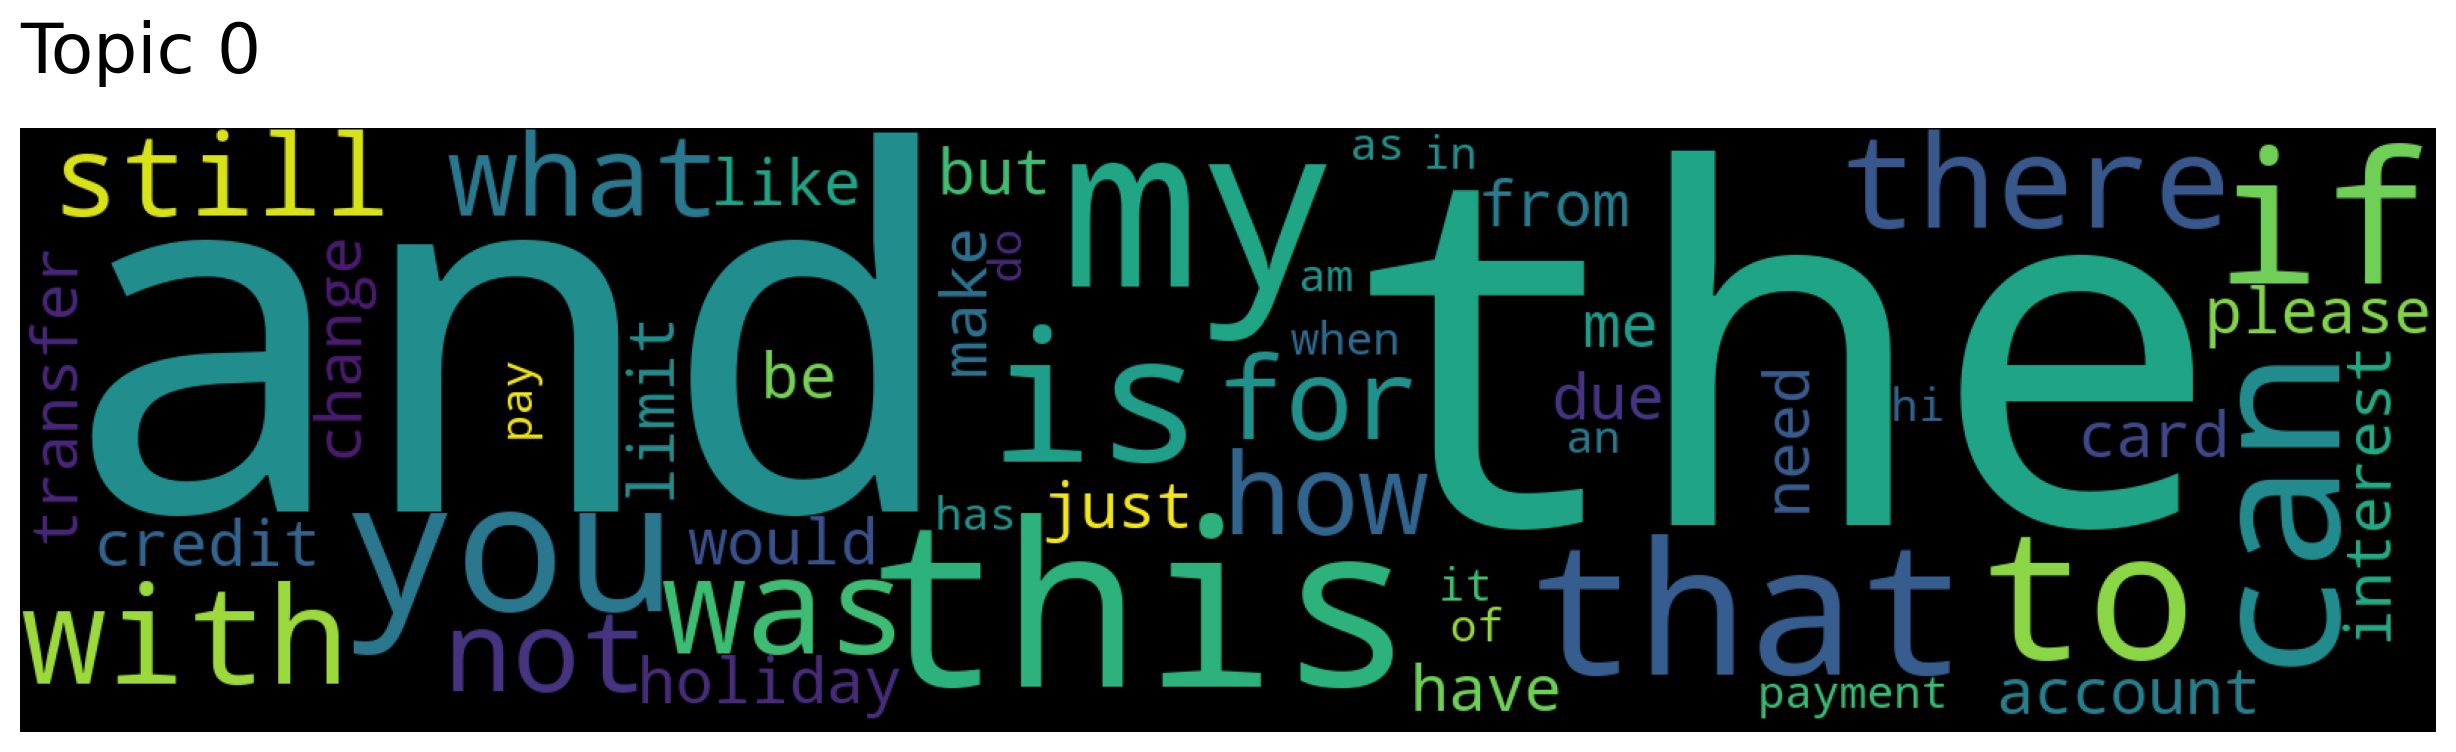

In [ ]:
# vis
# time.sleep(120)
model.generate_topic_wordcloud(0)

In [ ]:
# export
def evaluate(model):
    topic_words, word_scores, topic_nums = model.get_topics(model.get_num_topics())

    topic_contains_non_empty_words = all([len(tw) > 0 for tw in topic_words])
    word_scores_in_range = word_scores.min() >= 0.0 and word_scores.max() <= 1.0
    as_many_items_as_topics = (
        model.get_num_topics() == len(topic_words) == word_scores.shape[0]
    )
    return (
        topic_contains_non_empty_words
        and word_scores_in_range
        and as_many_items_as_topics
    )

In [ ]:
# slow
# debug
# Debug your Flow
# from metaflow import Metaflow
# os.environ['USER'] = 'e02079'
# flow = list(Metaflow())[0]
# run = flow.latest_run
# model2 = run['evaluate'].task.data.model

# Serve

In [ ]:
# export
def serve_num_topics(model):
    return model.get_num_topics()

In [ ]:
assert serve_num_topics(model) > 0

In [ ]:
# export
def serve_reduced_hierarchies(model, desired_num_topics):
    return model.hierarchical_topic_reduction(desired_num_topics)

In [ ]:
try:
    serve_reduced_hierarchies(model, -1)
except IndexError:
    print("Negative indexing not possible")
assert all(
    [
        type(tl) == list
        for tl in serve_reduced_hierarchies(
            model, np.random.choice(model.get_num_topics())
        )
    ]
)  # <= #topics
try:
    serve_reduced_hierarchies(model, model.get_num_topics() + 1)  # > #topics
except ValueError as ve:
    print(ve)

Negative indexing not possible
Number of topics must be less than 4.


# [NBDEV] Export all NBs to modules

$$\sum_{i=1}^{k+1}i$$

This version is displayed inline: $\sum_{i=1}^{k+1}i$ . You can include text before and after.

In [ ]:
from nbdev.export import notebook2script

notebook2script()

Converted core.ipynb.
Converted index.ipynb.
Converted top2vec.ipynb.
